In [2]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from hurst import compute_Hc
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import yfinance as yf
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
access_token = "9c7349b9a9bd3d17409758cb7e29e53f-7fcbdfe7bc0636788aa51f7e4a95601f"
account_id = "101-003-28600525-001"

accountID = account_id
access_token = access_token

api = API(access_token=access_token)

In [4]:
class Momentum_Hurst_RSI():

    def __init__(self, instrument, params, short_term_window, long_term_window, hurst_window ): # params: from, to, granularity
        self.instrument = instrument
        self.params = params
        self.ST_window = short_term_window
        self.LT_window = long_term_window
        # Hurst exponent
        self.hurst_window = hurst_window

        # RSI indicator, same as the short term window
        self.RSI_window = short_term_window
        self.prepare_data()
    

    def prepare_data(self):
        # Make a request
        r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
        data = api.request(r)

        # Extract date and closing price and form as a DataFrame
        dates = [candle['time'][:19] for candle in data['candles']]  # Intercept the first 10 characters to get the date
        close_prices = [float(candle['mid']['c']) for candle in data['candles']]  # Get Close Price

        # Create DataFrame, row_index: date; column: close price
        bt_data = pd.DataFrame(data=close_prices, index=pd.to_datetime(dates), columns=['Close_Price'])


        # Calculate the momentum and the Hurst exponent
        bt_data['ShortTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.ST_window)
        bt_data['LongTermMomentum'] = bt_data['Close_Price'] - bt_data['Close_Price'].shift(self.LT_window)    
        bt_data['Hurst'] = bt_data['Close_Price'].rolling(window=self.hurst_window).apply(lambda x: compute_Hc(x)[0])

        # Calculating the RSI
        rsi_indicator = RSIIndicator(close = bt_data['Close_Price'], window = self.RSI_window, fillna = False)
        RSI = rsi_indicator.rsi()

        # Adding the RSI to the dataframe
        bt_data['RSI'] = RSI

        # bt_data = bt_data.dropna()
        self.data = bt_data
        
    def strategy(self):
        
        data = self.data
         
        # data['Position'] = 1
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] > 0), 'Position'] = 1 # Hurst exponent greater than 0.5, short term and long term momentum greater than 0, buy
        data.loc[(data['Hurst'] > 0.5) & (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] < 0), 'Position'] = -1

        # Out of the market
        data.loc[(data['RSI'] <= 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = 1
        data.loc[(data['RSI'] > 70) & (data['Hurst'] > 0.5) & ((data['ShortTermMomentum'] > 0) & (data['LongTermMomentum'] < 0) | (data['ShortTermMomentum'] < 0) & (data['LongTermMomentum'] > 0)), 'Position'] = -1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] <= 70), 'Position'] = 1
        data.loc[(data['Hurst'] < 0.5) & (data['RSI'] > 70), 'Position'] = -1

        data['Signal'] = data['Position'].diff()
        data = data.dropna()

        data['Instrument_Returns'] = np.log(data['Close_Price']/data['Close_Price'].shift(1))
        data['Strategy_Returns'] = data['Instrument_Returns'] * data['Position'].shift(1)

        self.visualise_data = data
    
    def visualise_strategy(self):
        print('-------------------')
        print('Visualising the Strategy crossover period')
        bt_data = self.visualise_data
        plt.figure(figsize=(15, 5))
        plt.plot(bt_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt_data["ShortTermMomentum"], color='b', label='Short term Momentum')
        plt.plot(bt_data["LongTermMomentum"], color='r', label='Long term Momentum')
        plt.plot(bt_data["Hurst"], color='g', label='Hurst Exponent')

        # plot ‘buy crossover’ signals.
        # Because I have used +1 and -1,
        # A buy signal will be created when the position was -1 and it turned to +1
        # difference of +1 - -1 will give me 2

        plt.plot(bt_data[bt_data['Signal'] == 2].index,
                bt_data['Close_Price'][bt_data['Signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover ’ signals
        plt.plot(bt_data[bt_data['Signal'] == -2].index,
                bt_data['Close_Price'][bt_data['Signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Moving Averages Crossover {} Vs {}".format(self.ST_window, self.LT_window))
        plt.legend()
        plt.grid()
        plt.show()

    def performance(self):

        print('-------------------')
        print('Performance of the Strategy')
        print('-------------------')

        bt_data = self.visualise_data

        daily_ret = bt_data[['Instrument_Returns', 'Strategy_Returns']].mean()
        annual_ret = daily_ret * 252
        annual_regular_ret = np.exp(annual_ret) - 1

        print('Annual Regular Return:', annual_regular_ret)

        daily_std = bt_data[['Instrument_Returns', 'Strategy_Returns']].std()
        annual_std = daily_std * math.sqrt(252)
        daily_regular_std = (np.exp(bt_data[['Instrument_Returns', 'Strategy_Returns']]) - 1).std()
        annual_regular_std = daily_regular_std * math.sqrt(252)

        print('Annual Regular Standard Deviation:', annual_regular_std)

        sr = annual_regular_ret / annual_regular_std

        print('Sharpe Ratio:', sr)

    def returns_plot(self):
        bt_data = self.visualise_data
        title = 'Returns plot for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Instrument_Returns', 'Strategy_Returns']].cumsum().plot(title = title, figsize=(15, 6))
        plt.show()

    def drawdown(self):
        bt_data = self.visualise_data
        bt_data['Gross_Cum_Returns'] = bt_data['Strategy_Returns'].cumsum().apply(np.exp)
        bt_data['Cum_Max'] = bt_data['Gross_Cum_Returns'].cummax()

        title = 'Drawdown for Momentum with Hurst Strategy for {} Vs {}'.format(self.ST_window, self.LT_window)
        bt_data[['Gross_Cum_Returns', 'Cum_Max']].dropna().plot(title = title, figsize=(15, 6))

        drawdown = bt_data['Cum_Max'] - bt_data['Gross_Cum_Returns']

        print('The Maximum Drawdown is:', drawdown.max())
        print('-'*20)

        zero_periods = drawdown[drawdown == 0]
        delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
        print('The Longest Drawdown period is:', delta_values.max())

In [5]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple instruments
def calculate_metrics(data, prefix, target_return):
    daily_ret = data.mean()
    annual_ret = daily_ret * 252
    annual_regular_ret = np.exp(annual_ret) - 1

    daily_std = data.std()
    annual_std = daily_std * math.sqrt(252)
    
    # downside stddev
    return_diffs = (np.exp(data)-1) - target_return   #regular return
    #only care about downside part
    negative_return_diffs = return_diffs[return_diffs < 0]
    daily_downside_std = math.sqrt(np.mean(negative_return_diffs ** 2))
    annual_downside_std = daily_downside_std*math.sqrt(252)
    daily_sortino_ratio = (daily_ret - target_return) / daily_downside_std
    annual_sortino = daily_sortino_ratio*math.sqrt(252)

    daily_regular_std = (np.exp(data) - 1).std()
    annual_regular_std = daily_regular_std * math.sqrt(252)

    sr = annual_regular_ret / annual_regular_std

    print(f'Annual Regular Return ({prefix}):', annual_regular_ret)
    print(f'Annual Regular Standard Deviation ({prefix}):', annual_regular_std)
    print(f'Annual Regular Downside Standard Deviation Under Target Return={target_return} ({prefix}):', annual_downside_std)
    print(f'Sharpe Ratio ({prefix}):', sr)
    print(f'Sortino Ratio ({prefix}):', annual_sortino)
    print("-----")

-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.0001997759496812357
Annual Regular Standard Deviation (Instrument Returns): 0.0007563032635152989
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008413493808577113
Sharpe Ratio (Instrument Returns): 0.26414794080442905
Sortino Ratio (Instrument Returns): 0.23742336022145694
-----
Annual Regular Return (Strategy Returns): 0.000843304974935899
Annual Regular Standard Deviation (Strategy Returns): 0.0007545417167840336
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008035123233664765
Sharpe Ratio (Strategy Returns): 1.1176386357141224
Sortino Ratio (Strategy Returns): 1.0490811012662038
-----


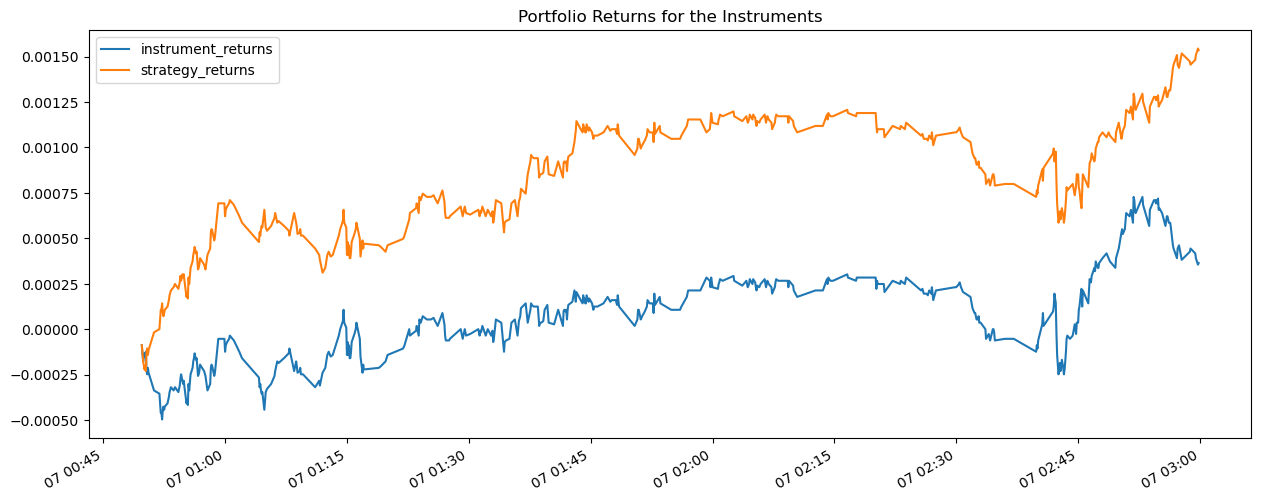

In [6]:
instruments_lis = "EUR_USD"
params = {
    "from": "2015-10-07T00:00:00Z",  # 开始时间
    "to": "2015-10-07T03:00:00Z",  # 结束时间
    "granularity": "S5",  # 日线数据
    "price":"M"
}


results = pd.DataFrame()


print('-------------------')
print('Running the Strategy for:', instruments_lis)
print('-------------------')
momentum_hurst_rsi = Momentum_Hurst_RSI(instruments_lis, params, 5, 21, 200)
t = momentum_hurst_rsi.data
momentum_hurst_rsi.strategy()
results['instrument_returns']=momentum_hurst_rsi.visualise_data['Instrument_Returns']
results['strategy_returns'] = momentum_hurst_rsi.visualise_data['Strategy_Returns']


plot_title = 'Portfolio Returns for the Instruments'

results.cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)


## 调参

In [13]:
# Function to calculate annual return, annual standard deviation and Sharpe ratio for multiple stocks
def run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window):
    results = pd.DataFrame() # create an empty dataframe to store the results

    print('-------------------')
    print('Running the Strategy for:', instruments_lis)
    print('-------------------')
    momentum_hurst_rsi = Momentum_Hurst_RSI(instruments_lis, params, short_window, long_window, hurst_window)
    t = momentum_hurst_rsi.data
    momentum_hurst_rsi.strategy()
    results['instrument_returns']=momentum_hurst_rsi.visualise_data['Instrument_Returns']
    results['strategy_returns'] = momentum_hurst_rsi.visualise_data['Strategy_Returns']


    plot_title = 'Portfolio Returns for the Instruments'

    results.cumsum().plot(title=plot_title, figsize=(15, 6))

    calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
    calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)
    return results

-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.0001997759496812357
Annual Regular Standard Deviation (Instrument Returns): 0.0007563032635152989
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008413493808577113
Sharpe Ratio (Instrument Returns): 0.26414794080442905
Sortino Ratio (Instrument Returns): 0.23742336022145694
-----
Annual Regular Return (Strategy Returns): 0.000843304974935899
Annual Regular Standard Deviation (Strategy Returns): 0.0007545417167840336
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008035123233664765
Sharpe Ratio (Strategy Returns): 1.1176386357141224
Sortino Ratio (Strategy Returns): 1.0490811012662038
-----


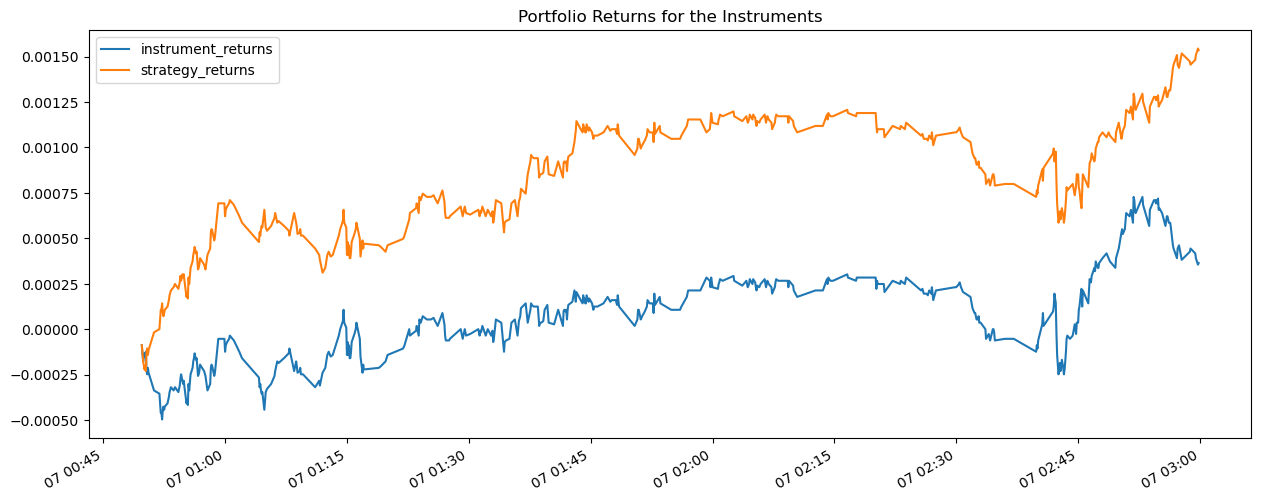

In [14]:
# Encapsulated function call， to run the strategy and analyze the results
instruments_lis = "EUR_USD"
params = {
    "from": "2015-10-07T00:00:00Z",  # 开始时间
    "to": "2015-10-07T03:00:00Z",  # 结束时间
    "granularity": "S5",  # 日线数据
    "price":"M"
}


short_window = 5
long_window = 21
hurst_window = 200

results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window=200)

-------------------
Running the Strategy for Short Window: 5
-------------------
-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.0001997759496812357
Annual Regular Standard Deviation (Instrument Returns): 0.0007563032635152989
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008413493808577113
Sharpe Ratio (Instrument Returns): 0.26414794080442905
Sortino Ratio (Instrument Returns): 0.23742336022145694
-----
Annual Regular Return (Strategy Returns): 0.000843304974935899
Annual Regular Standard Deviation (Strategy Returns): 0.0007545417167840336
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008035123233664765
Sharpe Ratio (Strategy Returns): 1.1176386357141224
Sortino Ratio (Strategy Returns): 1.0490811012662038
-----
-------------------
Running the Strategy for Short Window: 10
-------------------
-------------------
Running the Stra

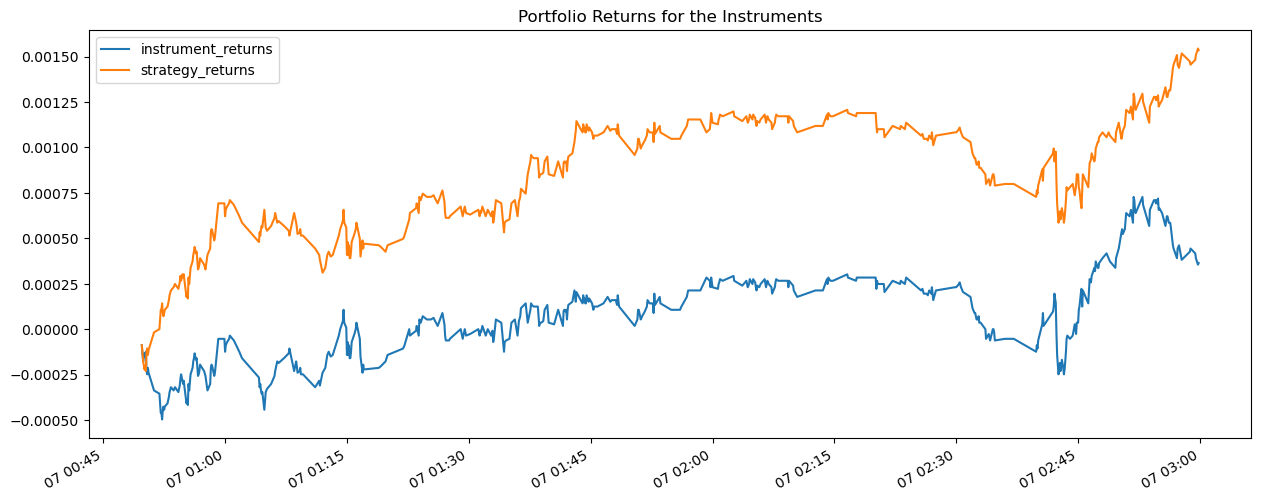

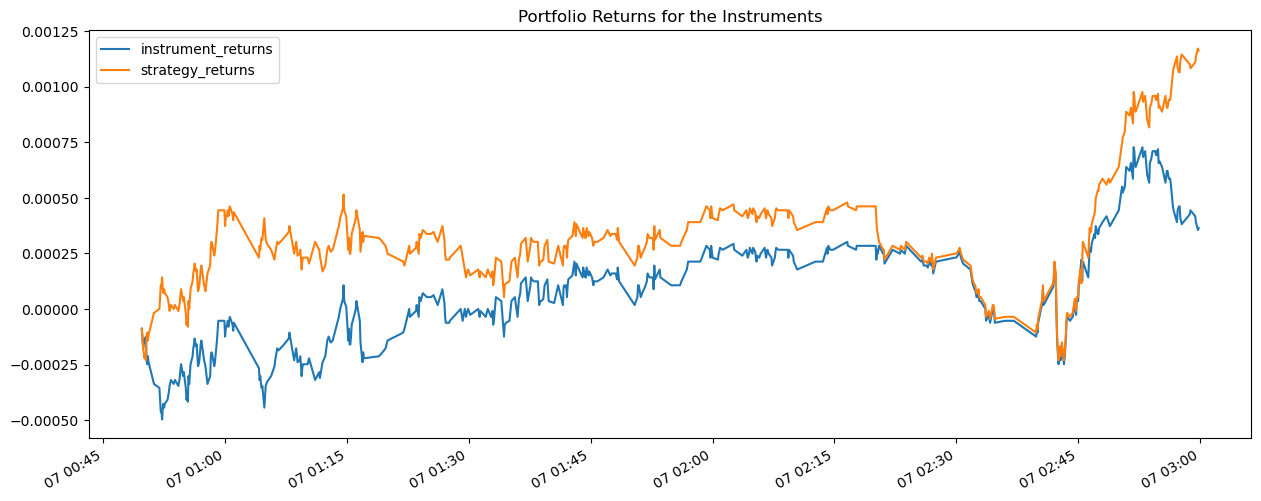

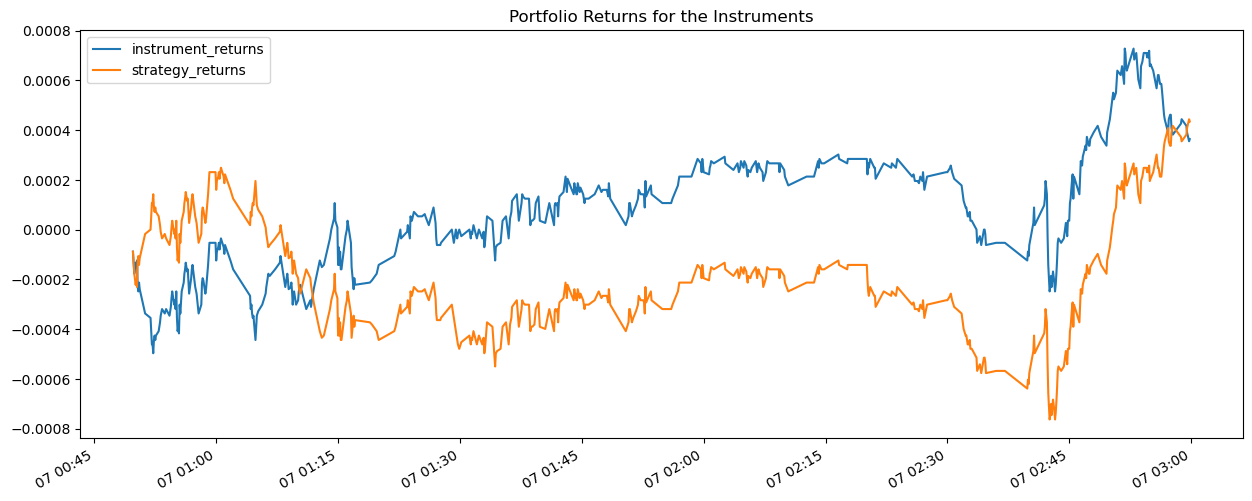

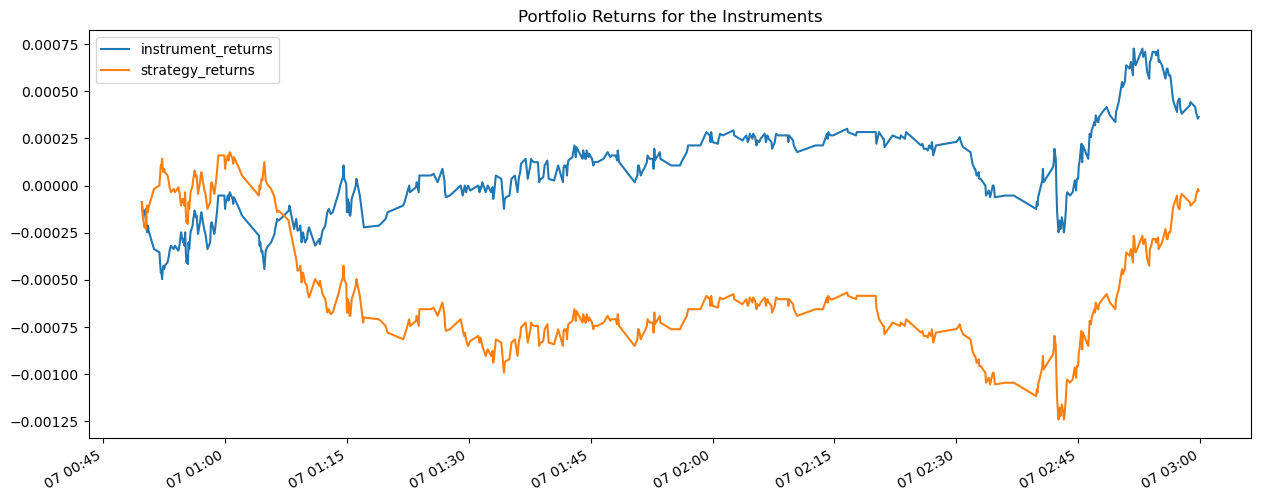

In [15]:
# Tune the parameters for the strategy, start with the short term window

for short_window in range(5,21 , 5):
    print('-------------------')
    print('Running the Strategy for Short Window:', short_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window=21, hurst_window=200)

## Comment

Based on our analysis, it appears that a window parameter value of 5 is the most optimal for short-term results. We will save these findings and proceed to evaluate additional parameters.

-------------------
Running the Strategy for Long Window: 11
-------------------
-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.00019890915654907637
Annual Regular Standard Deviation (Instrument Returns): 0.0007599586910088722
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008529473049855541
Sharpe Ratio (Instrument Returns): 0.26173680083192075
Sortino Ratio (Instrument Returns): 0.23317897317122663
-----
Annual Regular Return (Strategy Returns): 0.0004415900897078995
Annual Regular Standard Deviation (Strategy Returns): 0.0007595537064862945
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008289642089874101
Sharpe Ratio (Strategy Returns): 0.581380995098689
Sortino Ratio (Strategy Returns): 0.5325834489737503
-----
-------------------
Running the Strategy for Long Window: 13
-------------------
-------------------
Running the Stra

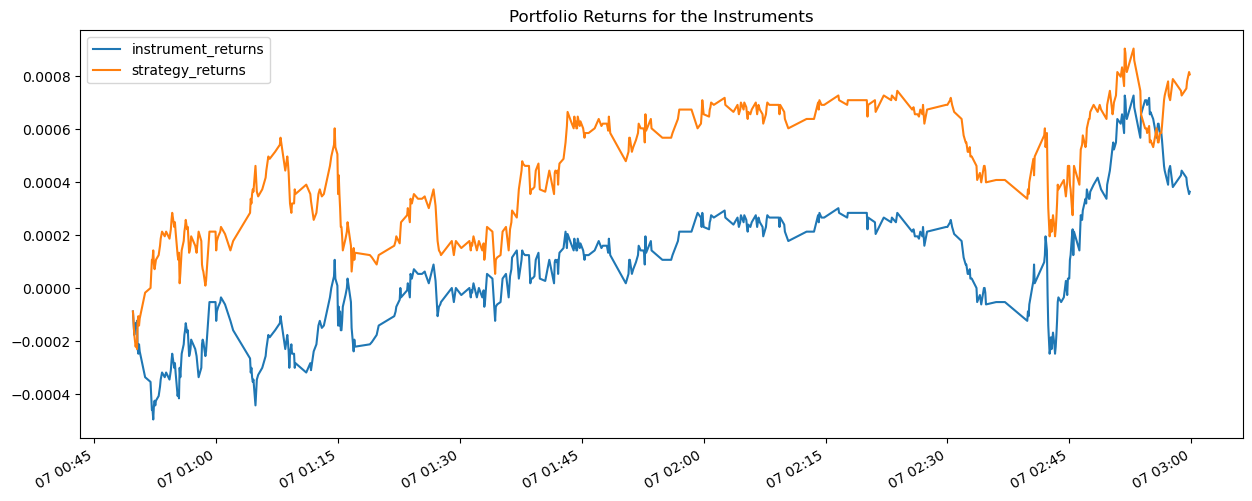

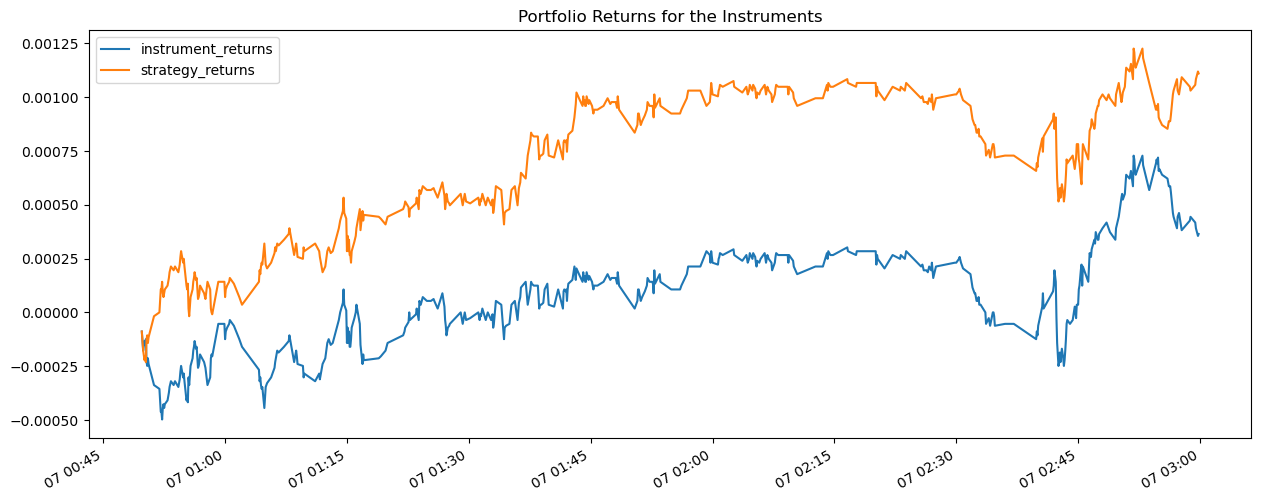

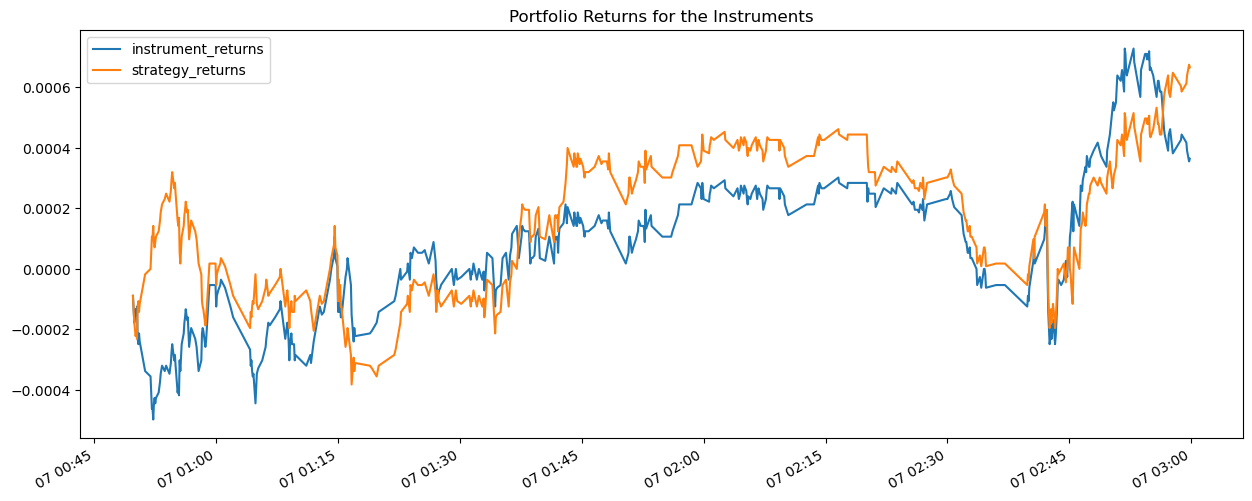

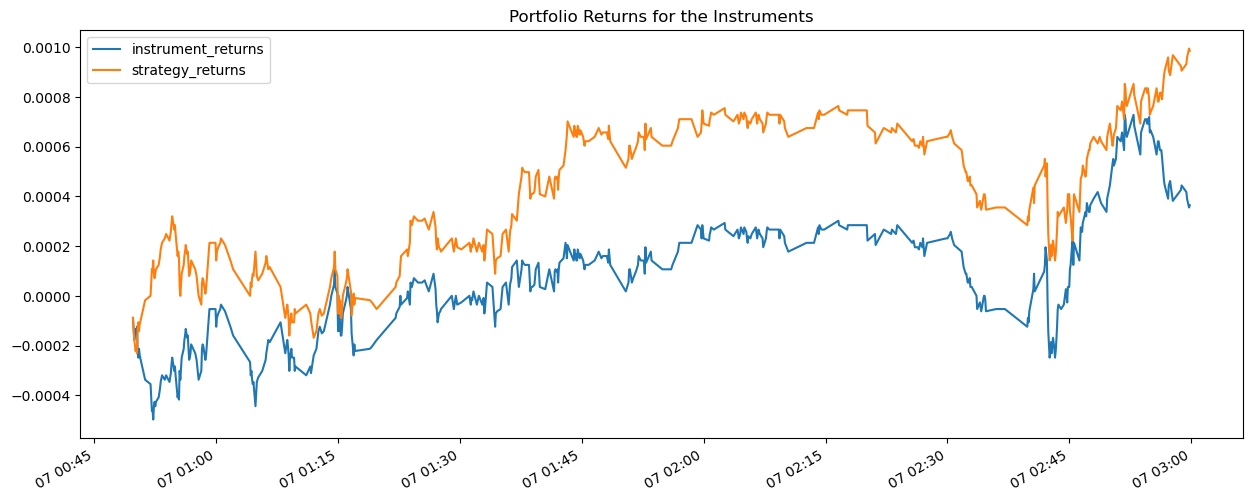

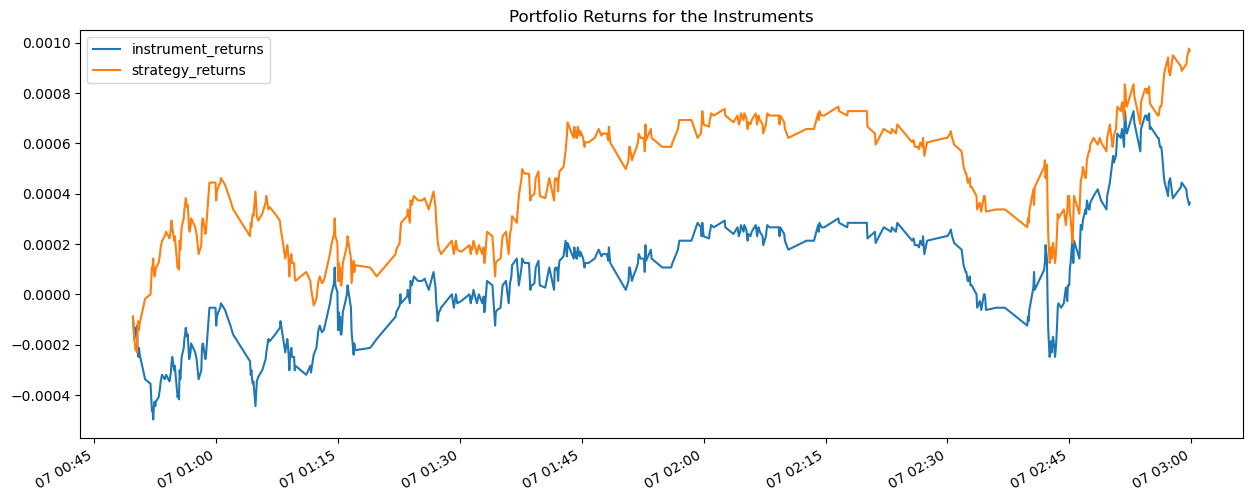

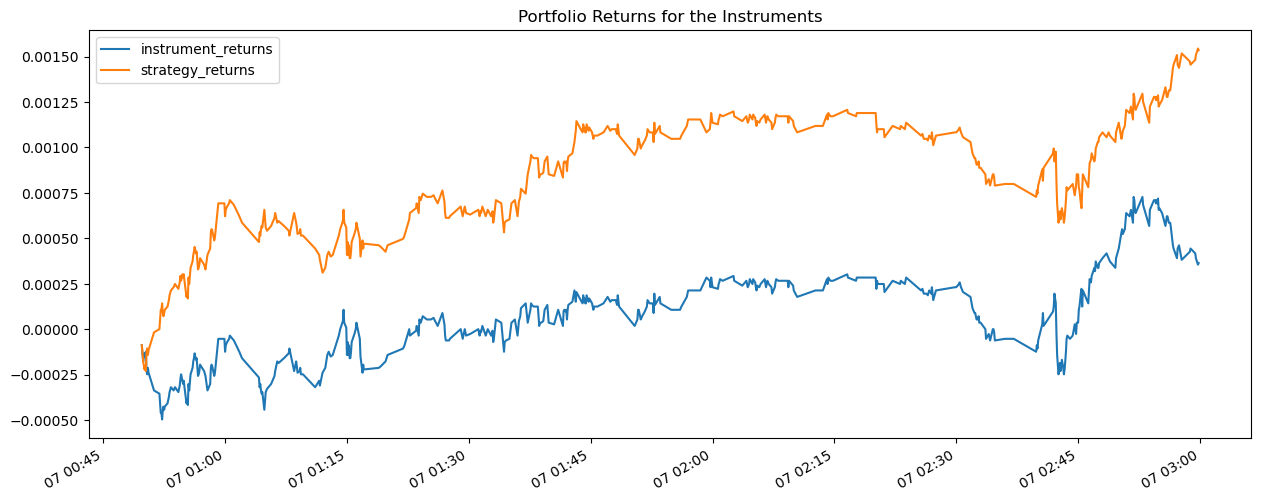

In [16]:
# Tune the parameters for the strategy, continue with the long term window
short_window =5

for long_window in range(11, 23, 2):
    print('-------------------')
    print('Running the Strategy for Long Window:', long_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis,params, short_window, long_window, hurst_window=200)

## Comment

Based on our analysis, it appears that a long_window parameter value of 21 is the most optimal for long-term results. We will save these findings and proceed to evaluate additional parameters.

-------------------
Running the Strategy for Hurst Window: 100
-------------------
-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): -4.013899307120372e-05
Annual Regular Standard Deviation (Instrument Returns): 0.0007690553364059944
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008585286711452458
Sharpe Ratio (Instrument Returns): -0.052192594175061835
Sortino Ratio (Instrument Returns): -0.04675417375239526
-----
Annual Regular Return (Strategy Returns): 0.001036538275517529
Annual Regular Standard Deviation (Strategy Returns): 0.0007662857678809376
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008090217214771203
Sharpe Ratio (Strategy Returns): 1.3526784901459663
Sortino Ratio (Strategy Returns): 1.280560723094284
-----
-------------------
Running the Strategy for Hurst Window: 200
-------------------
-------------------
Running th

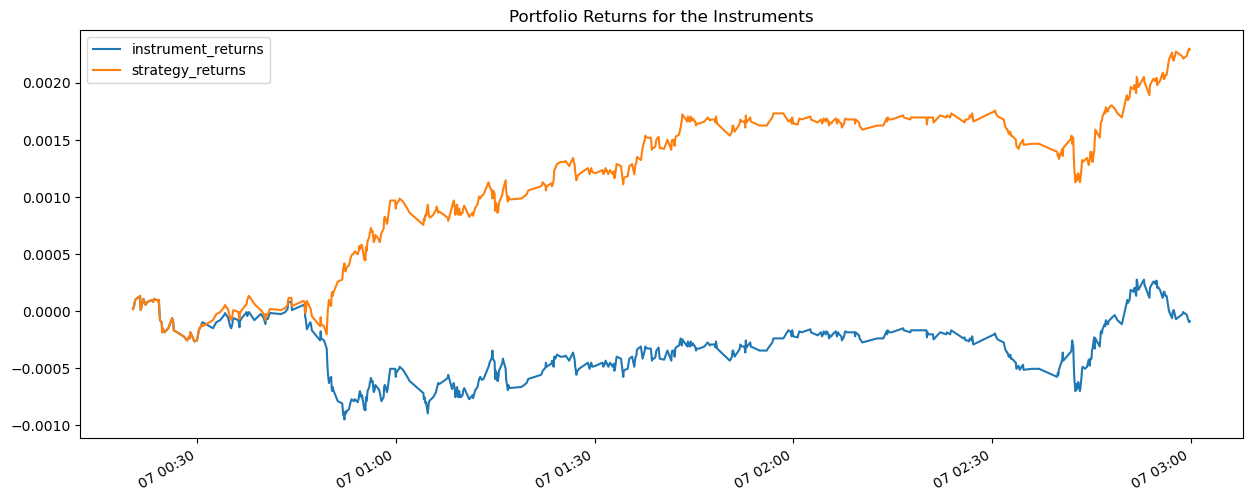

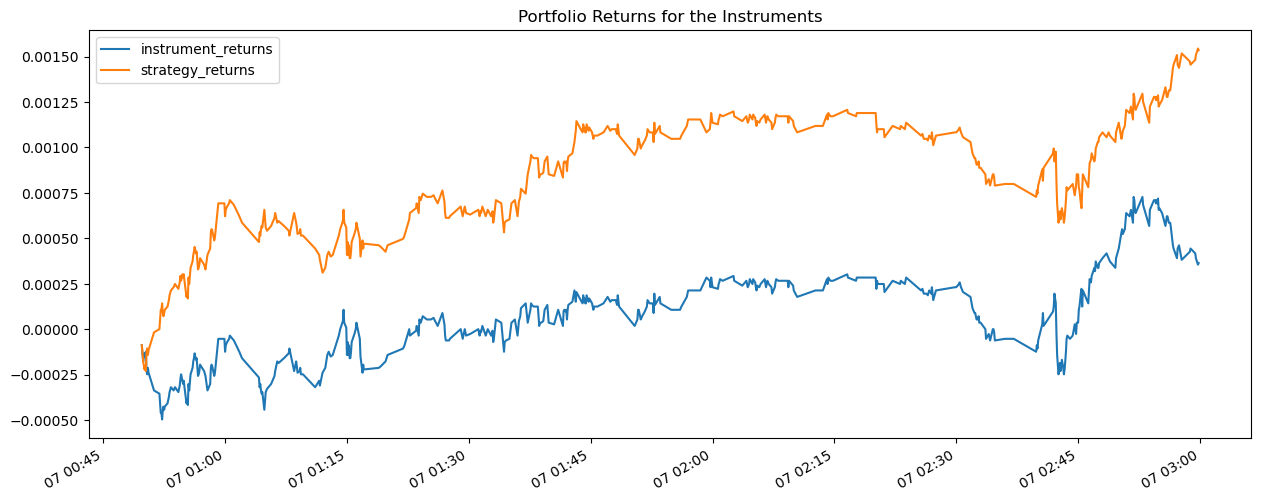

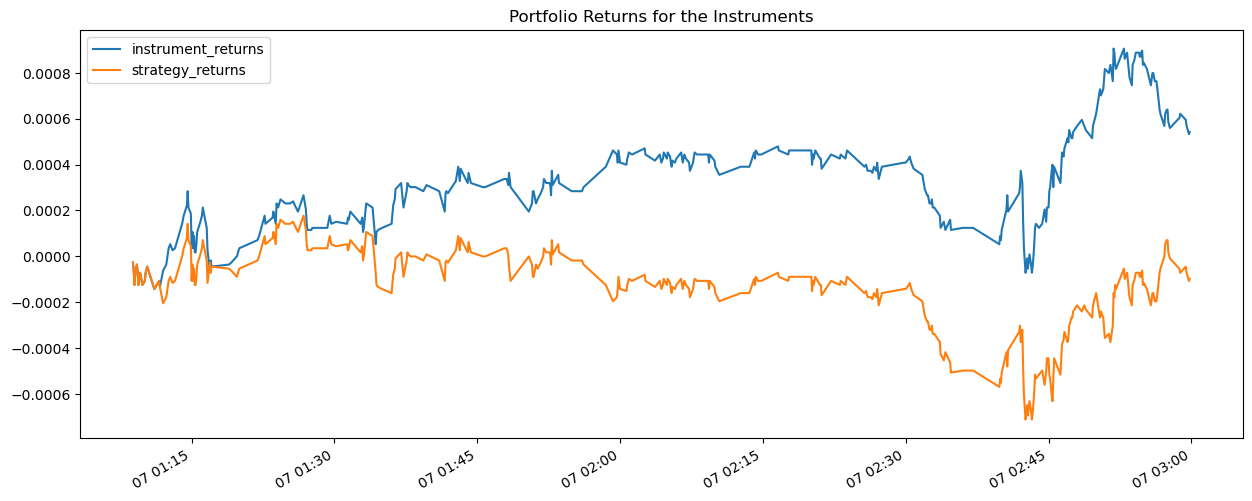

In [17]:
# Tune the parameters for the strategy, continue with the Hurst window
short_window =5
long_window = 21

for hurst_window in range(100, 301, 100):
    print('-------------------')
    print('Running the Strategy for Hurst Window:', hurst_window)
    print('-------------------')
    results2 = run_strategy_and_analyze(instruments_lis, params, short_window, long_window, hurst_window)

## Comment

Based on our analysis, it appears that a window parameter value of 200 is the most optimal for hurst_window results. 

## Conclusioin

We can get the best suitable combination for this strategy to get the best perfomance:

    short term window = 5,
    long term window = 21,
    hurst window = 200

# Backtest

-------------------
Running the Strategy for: EUR_USD
-------------------
Annual Regular Return (Instrument Returns): 0.0001997759496812357
Annual Regular Standard Deviation (Instrument Returns): 0.0007563032635152989
Annual Regular Downside Standard Deviation Under Target Return=0 (Instrument Returns): 0.0008413493808577113
Sharpe Ratio (Instrument Returns): 0.26414794080442905
Sortino Ratio (Instrument Returns): 0.23742336022145694
-----
Annual Regular Return (Strategy Returns): 0.000843304974935899
Annual Regular Standard Deviation (Strategy Returns): 0.0007545417167840336
Annual Regular Downside Standard Deviation Under Target Return=0 (Strategy Returns): 0.0008035123233664765
Sharpe Ratio (Strategy Returns): 1.1176386357141224
Sortino Ratio (Strategy Returns): 1.0490811012662038
-----


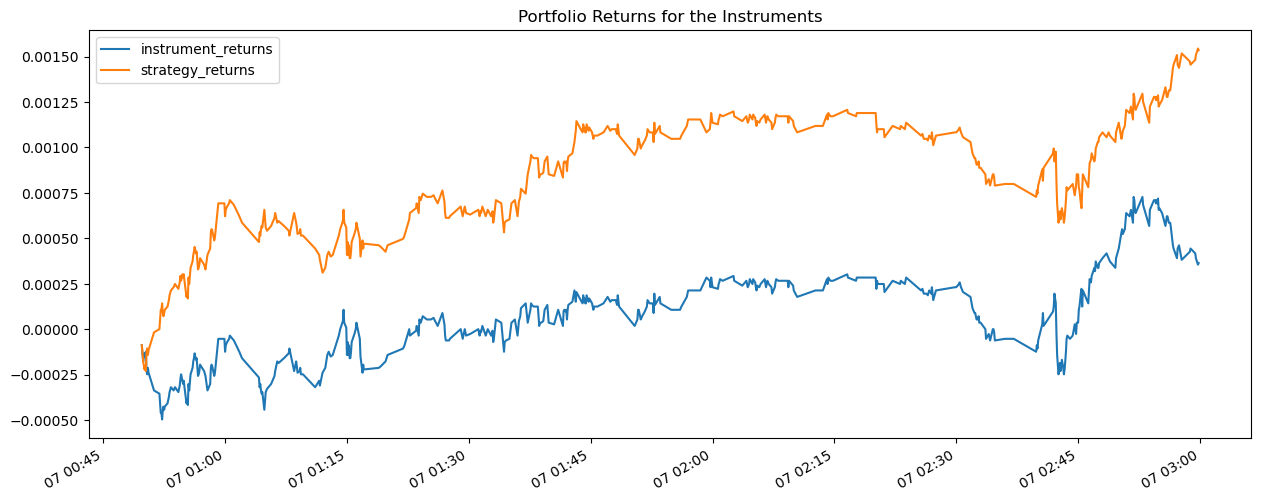

In [18]:
instruments_lis = "EUR_USD"
params = {
    "from": "2015-10-07T00:00:00Z",  # 开始时间
    "to": "2015-10-07T03:00:00Z",  # 结束时间
    "granularity": "S5",  # 日线数据
    "price":"M"
}


results = pd.DataFrame()


print('-------------------')
print('Running the Strategy for:', instruments_lis)
print('-------------------')
momentum_hurst_rsi = Momentum_Hurst_RSI(instruments_lis, params, 5, 21, 200)
t = momentum_hurst_rsi.data
momentum_hurst_rsi.strategy()
results['instrument_returns']=momentum_hurst_rsi.visualise_data['Instrument_Returns']
results['strategy_returns'] = momentum_hurst_rsi.visualise_data['Strategy_Returns']


plot_title = 'Portfolio Returns for the Instruments'

results.cumsum().plot(title=plot_title, figsize=(15, 6))

calculate_metrics(results['instrument_returns'], 'Instrument Returns', 0)
calculate_metrics(results['strategy_returns'], 'Strategy Returns', 0)
